#Import Libraries

In [ ]:
#Import Libraries

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ast 
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
from keras.models import Model

import warnings; warnings.simplefilter('ignore')

In [ ]:
# Install Kaggle API
!pip install -q kaggle

In [ ]:
# Upload Kaggle JSON file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rafifdarmawan","key":"162bfb2f0699e56854667a8ba8a5d7ca"}'}

In [ ]:
# Copy file to new directory
try: 
  !mkdir ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json
except FileExistsError:
  pass

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# Download Datasets

!kaggle competitions download -c job-recommendation

  0% 0.00/76.2k [00:00<?, ?B/s]
100% 76.2k/76.2k [00:00<00:00, 61.7MB/s]
 55% 9.00M/16.5M [00:00<00:00, 23.8MB/s]
100% 16.5M/16.5M [00:00<00:00, 33.5MB/s]
  0% 0.00/2.66k [00:00<?, ?B/s]
100% 2.66k/2.66k [00:00<00:00, 2.72MB/s]
  0% 0.00/493 [00:00<?, ?B/s]
100% 493/493 [00:00<00:00, 1.40MB/s]
 98% 658M/671M [00:08<00:00, 135MB/s]
100% 671M/671M [00:08<00:00, 84.3MB/s]
 96% 7.00M/7.28M [00:00<00:00, 71.0MB/s]
100% 7.28M/7.28M [00:00<00:00, 66.1MB/s]
 53% 9.00M/17.0M [00:00<00:00, 37.4MB/s]
100% 17.0M/17.0M [00:00<00:00, 47.9MB/s]
  0% 0.00/229k [00:00<?, ?B/s]
100% 229k/229k [00:00<00:00, 121MB/s]
  0% 0.00/8.26M [00:00<?, ?B/s]
100% 8.26M/8.26M [00:00<00:00, 75.8MB/s]
 66% 11.0M/16.6M [00:00<00:00, 32.8MB/s]
100% 16.6M/16.6M [00:00<00:00, 37.3MB/s]
 53% 9.00M/17.0M [00:00<00:00, 29.4MB/s]
100% 17.0M/17.0M [00:00<00:00, 48.5MB/s]
 62% 5.00M/8.11M [00:00<00:00, 38.1MB/s]
100% 8.11M/8.11M [00:00<00:00, 51.9MB/s]
 99% 663M/671M [00:09<00:00, 63.0MB/s]
100% 671M/671M [00:10<00:00, 70.3MB/s

In [ ]:
# Check downloaded files
!ls /content

apps.tsv.zip  popular_jobs.csv.zip  test_users.tsv	  users.tsv.zip
apps.zip      popular_jobs.py	    test_users.zip	  users.zip
jobs.zip      sample_data	    user_history.tsv.zip  window_dates.tsv
kaggle.json   splitjobs.zip	    user_history.zip


In [ ]:
# Unzip downloaded Datasets

!unzip /content/apps.tsv.zip
!unzip /content/jobs.zip
!unzip /content/users.tsv.zip

Archive:  /content/apps.tsv.zip
replace apps.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  /content/jobs.zip
replace jobs.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  /content/users.tsv.zip
replace users.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Read datasets as variables

jobs = pd.read_csv('/content/jobs.tsv', delimiter='\t',encoding='utf-8', error_bad_lines=False)
apps = pd.read_csv('/content/apps.tsv', delimiter='\t',encoding='utf-8')
users = pd.read_csv('/content/users.tsv' ,delimiter='\t',encoding='utf-8')

b'Skipping line 122433: expected 11 fields, saw 12\n'
b'Skipping line 602576: expected 11 fields, saw 12\n'
b'Skipping line 990950: expected 11 fields, saw 12\n'


In [ ]:
# Split data into training and testing

apps_training = apps.loc[apps['Split'] == 'Train']
apps_testing = apps.loc[apps['Split'] == 'Test']
users_training = users.loc[users['Split']=='Train']
users_testing = users.loc[users['Split']=='Test']

# Exploratory Data Analysis

In [ ]:
# Check users data
users_training.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience,CurrentlyEmployed,ManagedOthers,ManagedHowMany
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0,Yes,No,0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0,Yes,No,0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0,Yes,Yes,5
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0,Yes,No,0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0,Yes,No,0


In [ ]:
# Check user availability by country
user_by_country = users.groupby(['Country']).size().reset_index(name='User Amount').sort_values('User Amount',  ascending=False)
user_by_country.head()

,Country,User Amount
110,US,388499
48,IN,258
19,CA,113
85,PK,65
84,PH,60


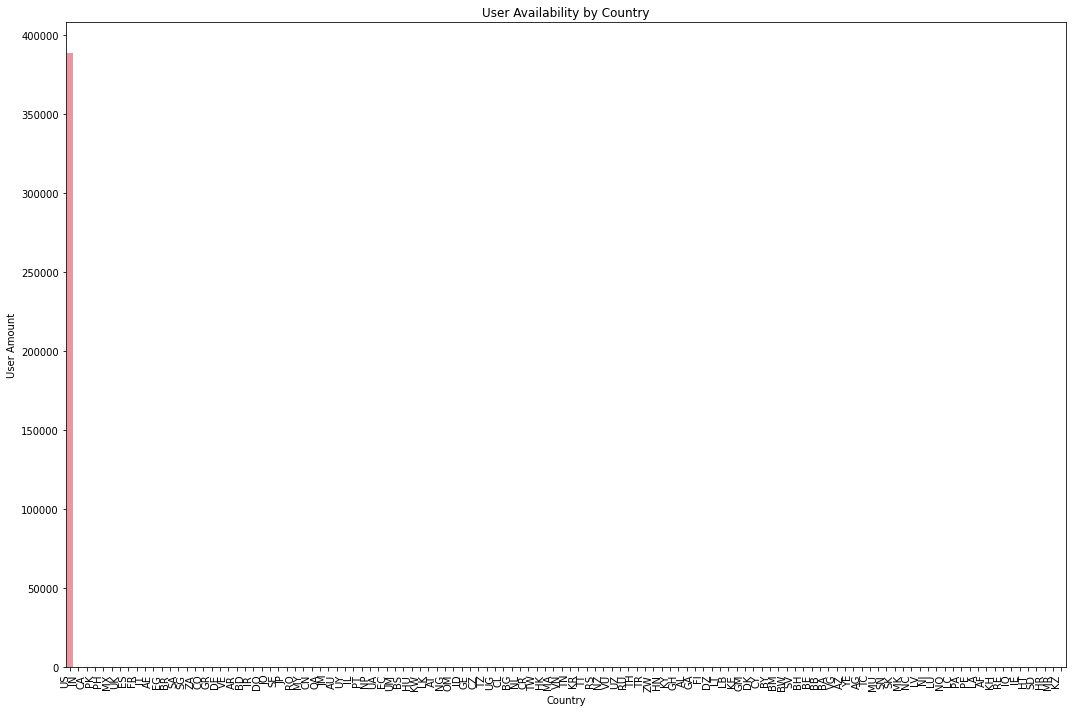

In [ ]:
# Plot a graph
plt.figure(figsize=(15,10))
ax = sns.barplot(x="Country", y="User Amount", data=user_by_country)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('User Availability by Country')
plt.tight_layout()
plt.show()

In [ ]:
# Filter user to only US Job seekers
user_filtered = users_training.loc[users_training['Country']=='US']

In [ ]:
# Only take columns 0-12 into consideration
user_final = user_filtered.iloc[0:10000,0:12]
user_final.head()

,UserID,WindowID,Split,City,State,Country,ZipCode,DegreeType,Major,GraduationDate,WorkHistoryCount,TotalYearsExperience
0,47,1,Train,Paramount,CA,US,90723,High School,NaN,1999-06-01 00:00:00,3,10.0
1,72,1,Train,La Mesa,CA,US,91941,Master's,Anthropology,2011-01-01 00:00:00,10,8.0
2,80,1,Train,Williamstown,NJ,US,08094,High School,Not Applicable,1985-06-01 00:00:00,5,11.0
3,98,1,Train,Astoria,NY,US,11105,Master's,Journalism,2007-05-01 00:00:00,3,3.0
4,123,1,Train,Baton Rouge,LA,US,70808,Bachelor's,Agricultural Business,2011-05-01 00:00:00,1,9.0


In [ ]:
#Combine all features into new column
user_final['DegreeType'] = user_final['DegreeType'].fillna('')
user_final['Major'] = user_final['Major'].fillna('')
user_final['TotalYearsExperience'] = str(user_final['TotalYearsExperience'].fillna(''))

user_final['Features'] = user_final['DegreeType'] + user_final['Major'] + user_final['TotalYearsExperience']

# Extract Features from Texts using Tfidf

In [ ]:
# Define TFidfVectorizer and create features matrix
tf_idf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tf_idf_matrix = tf_idf.fit_transform(user_final['Features'])

# Compute Similarity using Cosine Similarity

In [ ]:
# Tfidf gives normalized vectors, linear_kernel will give the same result as cosine_similarity
# linear_kernel is computationally faster
similarity = linear_kernel(tf_idf_matrix, tf_idf_matrix)

In [ ]:
similarity.shape

(10000, 10000)

In [ ]:
# Reset index for users ID
user_final = user_final.reset_index()
userid = user_final['UserID']
indices = pd.Series(user_final.index, index=user_final['UserID'])

In [ ]:
def get_recommendations_userwise(useridnum):
    idx = indices[useridnum]
    #print (idx)
    sim_scores = list(enumerate(similarity[idx]))
    #print (sim_scores)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    user_indices = [i[0] for i in sim_scores]
    #print (user_indices)
    return userid[user_indices[1:11]].values.tolist()

In [ ]:
print ("-----Top 10 Similar users with userId: 123------")
get_recommendations_userwise(123)

-----Top 10 Similar users with userId: 123------


[4095, 39199, 133161, 29118, 61859, 71735, 179432, 182995, 63776, 135105]

In [ ]:
def get_job_id(usrid_list):
    jobs_userwise = apps_training['UserID'].isin(usrid_list)
    df1 = pd.DataFrame(data = apps_training[jobs_userwise], columns=['JobID'])
    joblist = df1['JobID'].tolist()
    Job_list = jobs['JobID'].isin(joblist)
    df_temp = pd.DataFrame(data = jobs[Job_list], columns=['JobID','Title','Description','City','State'])
    return df_temp

In [ ]:
print("-----Top Recommended Jobs for userId: 123------")
get_job_id(get_recommendations_userwise(123))

-----Top Recommended Jobs for userId: 123------


,JobID,Title,Description,City,State
1813,7456,Inside Sales Representative,"<SPAN>American West Worldwide Express, a leade...",Mira Loma,CA
7355,27438,Broadband Sales Advisor,"<P style=""TEXT-ALIGN: center"" align=center><ST...",Fond du Lac,WI
46199,180366,Order Processor/Customer Service Rep,Volt Workforce Solutions is currently recruiti...,Palos Verdes Peninsula,CA
50610,198144,Supply Chain Planning Manager,INVISTA is the world's largest integrated prod...,Kennesaw,GA
63960,250919,Call Center Rep (Sales/Service) - West Covina,<br />\rImmediate Call Center Representative p...,West Covina,CA
68101,267068,Customer Service Specialist,<p>Immediate opening for a Customer Service Sp...,Cypress,CA
79814,313902,Customer Care Representative,<p>J. F. Ahern Co. has an excellent opportunit...,Fond du Lac,WI
112406,443789,Support Specialist III,"POSTING: March 19, 2012 <br>\r<br>\rPOSITION: ...",Fond du Lac,WI
126823,498355,INSIDE SALES REPRESENTATIVE,"<P STYLE=""MARGIN-TOP: 0px; MARGIN-BOTTOM: 0px""...",Irvine,CA
153547,602298,Customer Service Rep.,Customer Service Customer Service Rep. SANTA M...,Rancho Dominguez,CA


In [ ]:
print ("-----Top 10 Similar users with userId: 47------")
get_recommendations_userwise(47)

-----Top 10 Similar users with userId: 47------


[2386, 3594, 4740, 8828, 9337, 9886, 10635, 10904, 12332, 13838]

In [ ]:
print("-----Top Recommended Jobs for userId: 47------")
get_job_id(get_recommendations_userwise(47))

-----Top Recommended Jobs for userId: 47------


,JobID,Title,Description,City,State
14446,54371,Assistant Manager - Self Storage,<strong>Self Storage - Assistant Manager<br>\r...,Honolulu,HI
41730,165188,RETAIL SALES ASSOCIATE,<p>Jewelry Sales</p>\r<p>&nbsp;</p>\r<p><b>EXC...,Honolulu,HI
43561,171879,SR Secretary,<div>\r<p><b><span>SUMMARY</span></b><span><br...,Goldsboro,NC
45800,179675,Assistant Manager - Bakery,<p><b><span>SUMMARY: </span></b><span>The Bake...,Honolulu,HI
47079,184511,Assistant Restaurant Manager - Ala Moana,Nordstrom is a fashion specialty retailer foun...,Honolulu,HI
58681,230536,Counter Sales Representative,Do you enjoy a fast paced sales environment? D...,Honolulu,HI
79780,313825,Personal Home Assistant,"<div style=""text-align: center""><strong><span ...",Honolulu,HI
100845,395890,Retail Assistant Manager,<p>Badcock Home Furniture & more is one of the...,Goldsboro,NC
117019,461927,"Territory Sales Manager (Knoxville, TN)",Territory Sales Manager\r\nTerritory Sales Man...,Knoxville,TN
118098,466263,Telecom Field Technician,<p><span>• Proficiency in primary skills of cu...,Washington,DC
